# Sensor Data Processing

**An aim of the research** — find optimal parameters of digital electronic equipment utilized for adjustment of steel mechanical properties and build ML models for temperature prediction.

**An initial data**

Dataframes are extracted from the following files:
- `data_arc.csv` — electrode data;
- `data_bulk.csv` — bulk material feed data (volume);
- `data_bulk_time.csv` — bulk material feed data (time);
- `data_gas.csv` — gas purge data;
- `data_temp.csv` — temperature measurements;
- `data_wire.csv` — wire material feed data (volume);
- `data_wire_time.csv` — wire material feed data (time).

The research is divided into four steps:
  1. Work plan and exploratory data analysis
  2. Clarification of the defined tasks
  3. Data pre-processing and ML model building
  4. Compilation of a report

## Step 1. Work plan and exploratory data analysis

### Work plan

1. Calculation of technological process parameters:
- Time period between the first and last temperature measurement
- Total time of heating by electrodes
- Number of electrode heating starts
- Average ratio of active and reactive power
- Additional parameters for steel processing (min, max, avg, median)
2. Statistical analysis and data preprocessing
- Visualization of initial data
- Determination of dependencies between data attributes
- Identification of the most significant attributes influencing the target
- Removing some attributes to reduce data processing time
3. Building machine learning models
- Application of different algorithms for the current research task
- Determination of optimal hyper-parameters of models
- Optimization of models for achieveing the quality metric MAE<6
- Comparison and selection of the model with the smallest error
4. Approaches used to solve the regression problem
- Linear models (TheilSen, Lasso, SVM)
- Nonlinear models (RandomForest, GradientBoosting, XGBoost, LightGBM, CatBoost)
- GridSearch method for selecting the optimal combination of parameters
- DummyRegressor model for checking model's adequacy
- Building a pipeline/ ensemble from several models with the best metrics

### Data overview

In [143]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import statistics as st

from functools import reduce
from itertools import combinations
from IPython.display import Image
from IPython.core.display import HTML   

from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import VotingRegressor

In [2]:
# set global parameters
sns.set(style='darkgrid') 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')

In [3]:
# random seed
SEED = 141122

In [4]:
# define path to directories
path1 = '/datasets/final_steel/'
path2 = 'C:/YandexPracticumProjects/Project_15_PhaseDiagram_ML/'

#### Electrode performance

In [5]:
# read data on electrode performance (generated power, W)
try:
    arc_df = pd.read_csv(path1 + '/data_arc.csv')
except:  
    arc_df = pd.read_csv(path2 + '/data_arc.csv')

In [6]:
# info on electrode performance
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
# rename columns 
arc_df = arc_df.rename(columns={
    'Начало нагрева дугой': 'Start of arc heating', 
    'Конец нагрева дугой': 'End of arc heating',
    'Активная мощность': 'Active power',
    'Реактивная мощность': 'Reactive power'
})

In [8]:
# print out 10 rows
arc_df.loc[0:9].style

,key,Start of arc heating,End of arc heating,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.44,0.28
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.30,0.89
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.49,0.31
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.83,0.52
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.06,0.67


#### Bulk doping materials (volume)

In [9]:
# read data on bulk doping materials (volume, m3)
try:
    bulk_df = pd.read_csv(path1 + '/data_bulk.csv')
except:  
    bulk_df = pd.read_csv(path2 + '/data_bulk.csv')

In [10]:
# info on bulk doping materials (volume)
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
# print out 10 rows
bulk_df.loc[0:9].style

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,43.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,150.00,154.00
1,2,nan,nan,nan,73.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,149.00,154.00
2,3,nan,nan,nan,34.00,nan,nan,nan,nan,nan,nan,nan,205.00,nan,152.00,153.00
3,4,nan,nan,nan,81.00,nan,nan,nan,nan,nan,nan,nan,207.00,nan,153.00,154.00
4,5,nan,nan,nan,78.00,nan,nan,nan,nan,nan,nan,nan,203.00,nan,151.00,152.00
5,6,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,204.00,nan,201.00,154.00
6,7,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,204.00,nan,152.00,154.00
7,8,nan,nan,nan,99.00,nan,nan,nan,nan,nan,nan,nan,410.00,nan,252.00,153.00
8,9,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,107.00,nan,99.00,203.00
9,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,203.00,nan,102.00,204.00


#### Bulk doping materials (time)

In [12]:
# read data on bulk doping materials (time, sec) 
try:
    bulk_time_df = pd.read_csv(path1 + '/data_bulk_time.csv')
except:  
    bulk_time_df = pd.read_csv(path2 + '/data_bulk_time.csv')

In [13]:
# info on bulk doping materials (time)
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
# print out 10 rows
bulk_time_df.loc[0:9].style

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,2019-05-03 11:21:30,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:03:52,nan,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,nan,nan,nan,2019-05-03 11:46:38,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:40:20,nan,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,nan,nan,nan,2019-05-03 12:31:06,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:09:40,nan,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,nan,nan,nan,2019-05-03 12:48:43,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:41:24,nan,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,nan,nan,nan,2019-05-03 13:18:50,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:12:56,nan,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,nan,nan,nan,2019-05-03 13:59:24,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:53:27,nan,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,nan,nan,nan,2019-05-03 14:29:14,nan,nan,nan,nan,nan,nan,nan,2019-05-03 14:22:19,nan,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,nan,nan,nan,2019-05-03 15:04:05,nan,nan,nan,nan,nan,nan,nan,2019-05-03 14:55:46,nan,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,nan,nan,nan,2019-05-03 15:47:34,nan,nan,nan,nan,nan,nan,nan,2019-05-03 15:41:00,nan,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2019-05-03 16:18:52,nan,2019-05-03 16:18:52,2019-05-03 16:18:52


#### Purging gas (flowrate)

In [15]:
# read data on gas purge of steel (flowrate, m3/sec)
try:
    gas_df = pd.read_csv(path1 + '/data_gas.csv')
except:  
    gas_df = pd.read_csv(path2 + '/data_gas.csv')

In [16]:
# info on gas purge of steel (flowrate)
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
# rename column 
gas_df = gas_df.rename(columns={'Газ 1': 'Gas'})

In [18]:
# print out 10 rows
gas_df.loc[0:9].style

,key,Gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41
5,6,11.27
6,7,9.84
7,8,15.17
8,9,8.22
9,10,6.53


#### Temperature measured

In [19]:
# read data on temperature measured (Celsius)
try:
    temp_df = pd.read_csv(path1 + '/data_temp.csv')
except:  
    temp_df = pd.read_csv(path2 + '/data_temp.csv')

In [20]:
# info on temperature measured
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [21]:
# rename columns 
temp_df = temp_df.rename(columns={
    'Время замера': 'Date of measurement', 
    'Температура': 'Temperature',
})

In [22]:
# print out 10 rows
temp_df.loc[0:9].style

,key,Date of measurement,Temperature
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00
5,2,2019-05-03 11:37:27,1581.00
6,2,2019-05-03 11:38:00,1577.00
7,2,2019-05-03 11:49:38,1589.00
8,2,2019-05-03 11:55:50,1604.00
9,2,2019-05-03 11:58:24,1608.00


#### Wire doping materials (volume) 

In [23]:
# read data on wire doping materials (volume, m3)
try:
    wire_df = pd.read_csv(path1 + '/data_wire.csv')
except:  
    wire_df = pd.read_csv(path2 + '/data_wire.csv')

In [24]:
# info on wire doping materials (volume)
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [25]:
# print out 10 rows
wire_df.loc[0:9].style

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.05,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.16,nan,nan,nan,nan,nan,nan,nan,nan
3,4,89.06,nan,nan,nan,nan,nan,nan,nan,nan
4,5,89.24,9.11,nan,nan,nan,nan,nan,nan,nan
5,6,99.11,9.11,nan,nan,nan,nan,nan,nan,nan
6,7,98.06,nan,nan,nan,nan,nan,nan,nan,nan
7,8,155.28,nan,nan,nan,nan,nan,nan,nan,nan
8,9,113.39,9.14,nan,nan,nan,nan,nan,nan,nan
9,10,81.24,12.38,nan,nan,nan,nan,nan,nan,nan


#### Wire doping materials (time) 

In [26]:
# read data on wire doping materials (time, sec)
try:
    wire_time_df = pd.read_csv(path1 + '/data_wire_time.csv')
except:  
    wire_time_df = pd.read_csv(path2 + '/data_wire_time.csv')

In [27]:
# info on wire doping materials (time)
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [28]:
# print out 10 rows
wire_time_df.loc[0:9].style

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,nan,nan,nan,nan,nan,nan,nan,nan
1,2,2019-05-03 11:46:10,nan,nan,nan,nan,nan,nan,nan,nan
2,3,2019-05-03 12:13:47,nan,nan,nan,nan,nan,nan,nan,nan
3,4,2019-05-03 12:48:05,nan,nan,nan,nan,nan,nan,nan,nan
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,nan,nan,nan,nan,nan,nan,nan
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,nan,nan,nan,nan,nan,nan,nan
6,7,2019-05-03 14:28:46,nan,nan,nan,nan,nan,nan,nan,nan
7,8,2019-05-03 15:03:42,nan,nan,nan,nan,nan,nan,nan,nan
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,nan,nan,nan,nan,nan,nan,nan
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,nan,nan,nan,nan,nan,nan,nan


Measurements are made several times in datasets with steel temperature and electrode characteristics for the same trial, which is shown in the fields: Date of measurement, Start of arc heating and End of arc heating. The measurement time in other datasets corresponds to one entry in the table (trial).

All datasets have NaN values, which further when preprocessing the data, will either have to be replaced by zero, or the average value should be substituted. Records with missing measurement date will be replaced in accordance with neighboring values.

The number of records for the temperature and power of the electrodes is about 15,000. In the future, when forming a general table, they will be grouped in such a way that they can be combined with data on materials and purge gas, which average 3,000 rows.

### Exploratory data analysis

In [29]:
# additional parameters for vizualization
color = [['skyblue', 'olive', 'gold'], 
         ['teal', 'limegreen', 'lightcoral'], 
         ['violet', 'peru', 'aqua'],
         ['palegreen', 'khaki', 'salmon'],
         ['royalblue', 'teal', 'darkorange']]

wire = [[wire_df.columns[1], wire_df.columns[2], wire_df.columns[3]], 
        [wire_df.columns[4], wire_df.columns[5], wire_df.columns[6]], 
        [wire_df.columns[7], wire_df.columns[8], wire_df.columns[9]]] 

bulk = [[bulk_df.columns[1], bulk_df.columns[2], bulk_df.columns[3]], 
        [bulk_df.columns[4], bulk_df.columns[5], bulk_df.columns[6]], 
        [bulk_df.columns[7], bulk_df.columns[8], bulk_df.columns[9]],
        [bulk_df.columns[10], bulk_df.columns[11], bulk_df.columns[12]],
        [bulk_df.columns[13], bulk_df.columns[14], bulk_df.columns[15]]] 

In [30]:
# function for building multiple histograms
def mult_hist(data, row, col, param, x_axis, color, figsize):    
    sns.set(style='darkgrid')

    fig, axs = plt.subplots(row, col, figsize=figsize)
    fig.suptitle('Volume of {} materials ($m^3$)'.format(param), fontsize=17)

    for i in range(row):
        for j in range(col):
            sns.histplot(data=data, x=x_axis[i][j], kde=True, color=color[i][j], ax=axs[i, j]) 

    plt.show()

In [31]:
# function for plotting electrode performance
def proj_hist():    
    ax = arc_df['Active power'].plot(
        kind='hist', 
        histtype='barstacked', 
        bins=60, 
        linewidth=5, 
        alpha=1, 
        label='Active power', 
        grid=True, 
        legend=True, 
        range=(0, 2), 
        figsize=(15, 10), 
        facecolor='g'
    )
    arc_df['Reactive power'].plot(
        kind='hist', 
        histtype='barstacked', 
        bins=60, 
        linewidth=5, 
        alpha=0.6, 
        label='Reactive power', 
        ax=ax, grid=True, 
        legend=True, 
        range=(0, 2), 
        facecolor='r'
    )
    plt.title('Electrode performance (W)', fontsize=15);

#### Electrode performance

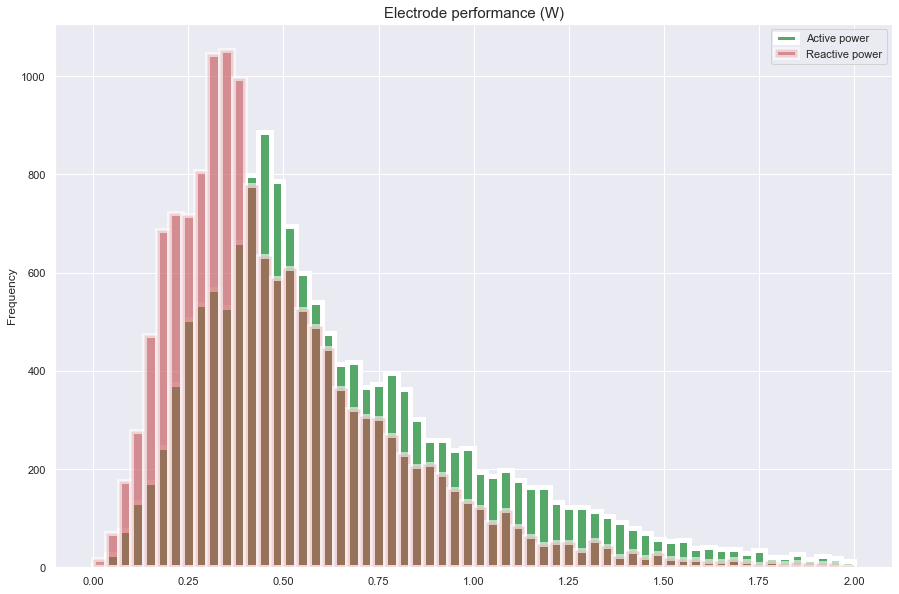

In [32]:
# distributions of active and reactive power
proj_hist()    

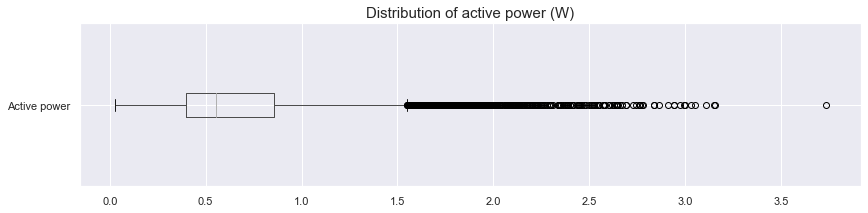

In [33]:
# boxplot of active power distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = arc_df[['Active power']].boxplot(vert=False, ax=ax)
ax.set_title('Distribution of active power (W)', fontsize=15);

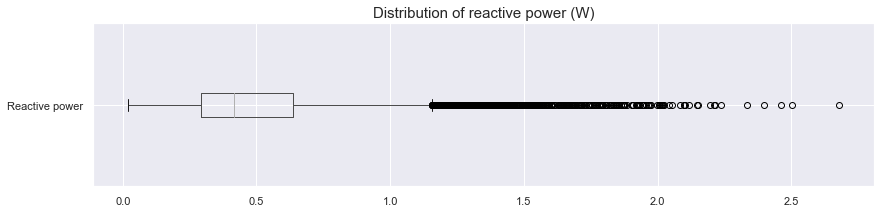

In [34]:
# boxplot of reactive power distribution
fig, ax = plt.subplots(figsize=(14, 3))
arc_t_df = arc_df[arc_df['Reactive power'] > 0]
ax = arc_t_df[['Reactive power']].boxplot(vert=False, ax=ax)
ax.set_title('Distribution of reactive power (W)', fontsize=15);

#### Bulk doping materials

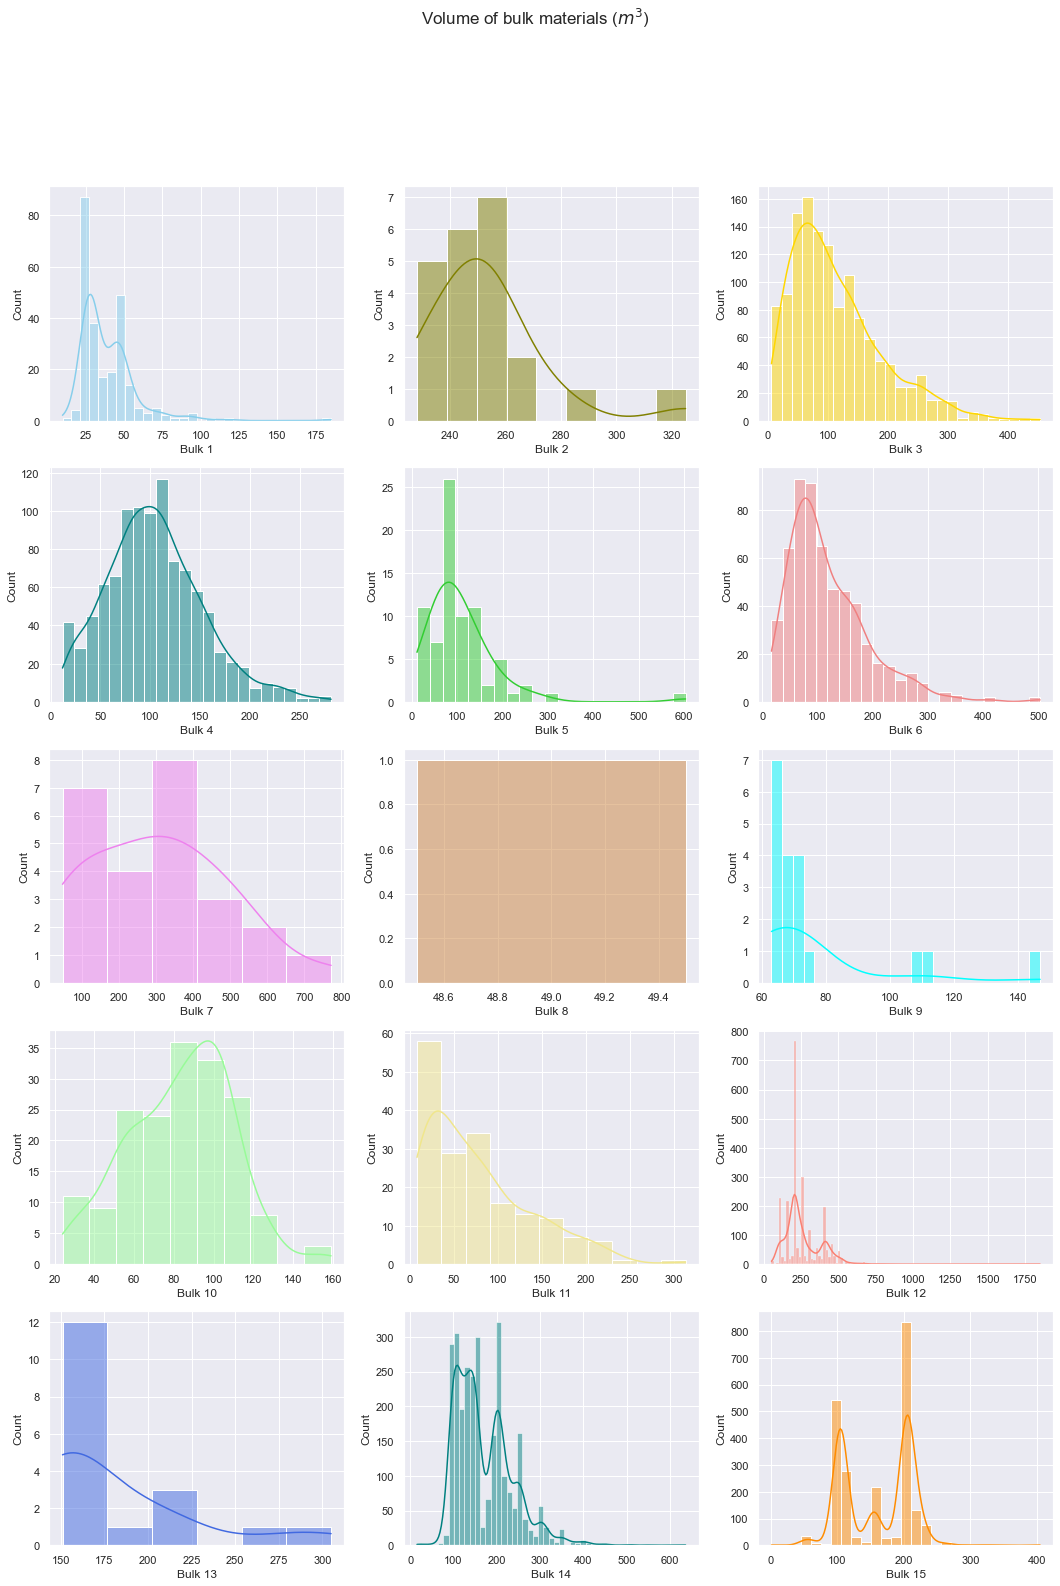

In [35]:
# histograms of bulk doping materials
mult_hist(bulk_df, row=5, col=3, param='bulk', x_axis=bulk, color=color, figsize=(18, 25))

#### Purging gas

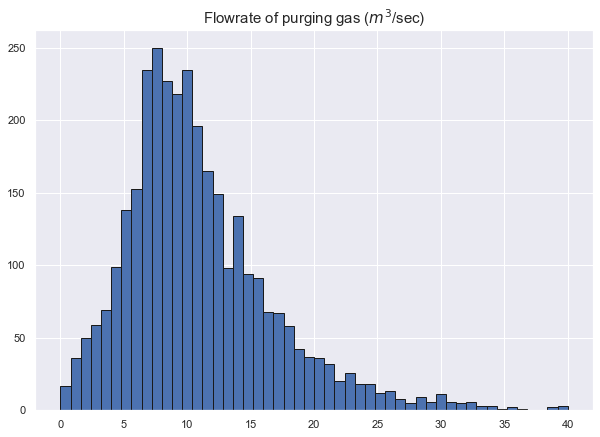

In [36]:
# histogram of purging gas distribution
gas_df.hist('Gas', bins=50, range=(0, 40), ec='k', figsize=(10, 7))
plt.title('Flowrate of purging gas ($m^3$/sec)', fontsize=15);

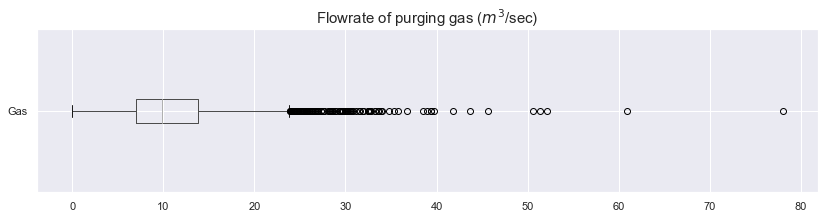

In [37]:
# boxplot of purging gas distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = gas_df[['Gas']].boxplot(vert=False, ax=ax)
ax.set_title('Flowrate of purging gas ($m^3$/sec)', fontsize=15);

#### Temperature measured

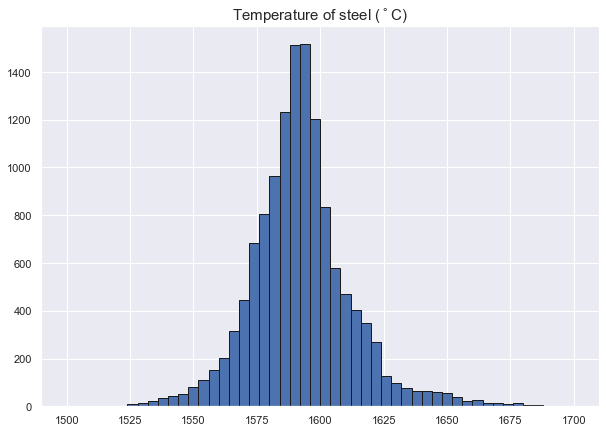

In [38]:
# histogram of temperature distribution
temp_df.hist('Temperature', bins=50, range=(1500, 1700), ec='k', figsize=(10, 7))
plt.title('Temperature of steel ($^\circ$C)', fontsize=15);

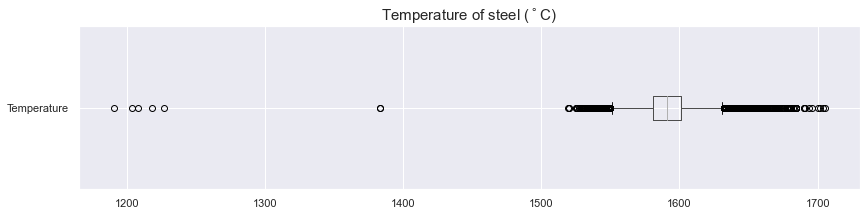

In [39]:
# boxplot of temperature distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = temp_df[['Temperature']].boxplot(vert=False, ax=ax)
ax.set_title('Temperature of steel ($^\circ$C)', fontsize=15);

#### Wire doping materials

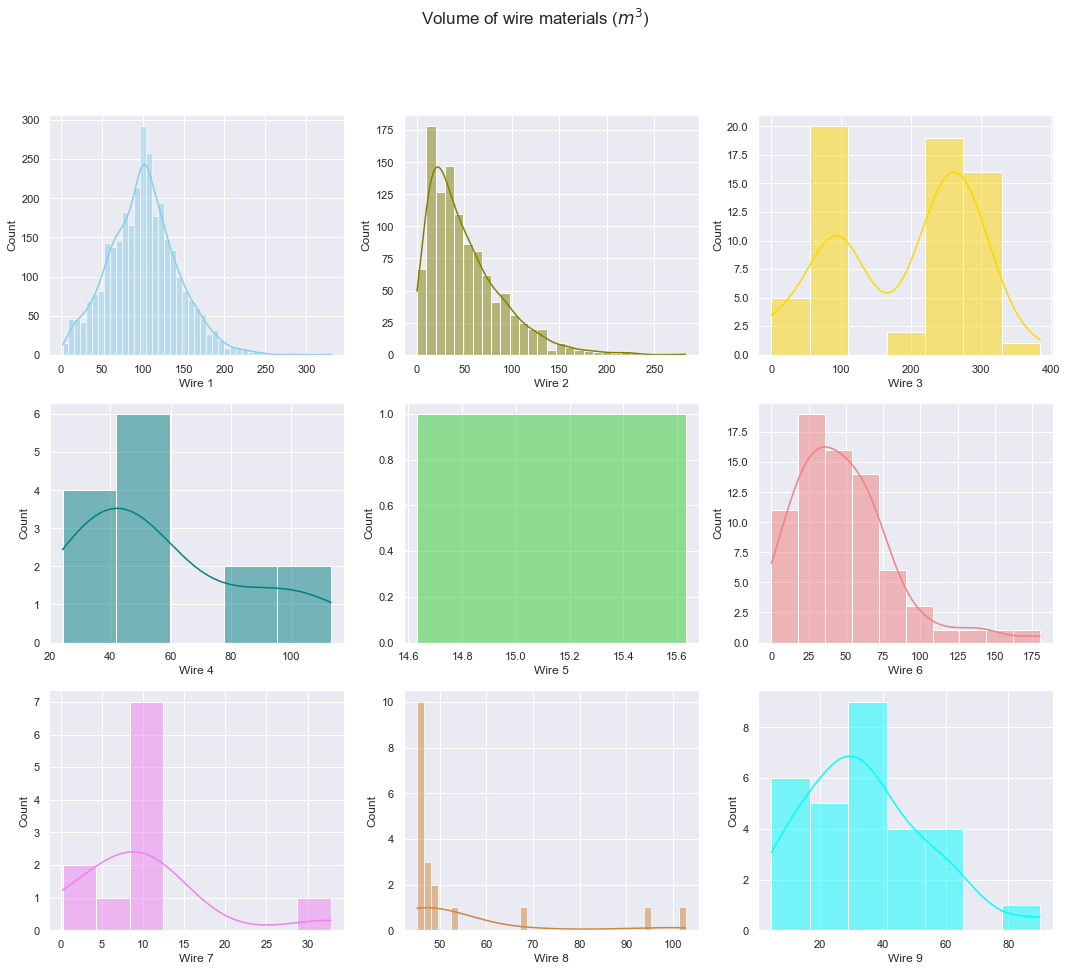

In [40]:
# histograms of wire doping materials
mult_hist(wire_df, row=3, col=3, param='wire', x_axis=wire, color=color, figsize=(18, 15))

Statistical analysis shows that the distribution of the target (temperature) is normal, the median temperature is approximately equal to 1590 C. The lower limit of the boxplot is 1525 C, the upper 1675 C is 1.5 interquartile range added to the 3rd quartile. This is the approximate limit of the normal range. Everything behind it is considered an outlier.

The main key parameter in predicting the temperature of steel is the characteristics of the electrodes. Their values are also normally distributed, although they are shifted to the left towards zero power. The median value of the active power is about 0.6 W, the reactive power is about 0.35 W, while their maximum difference can reach 1 W, which can be seen when the distributions intersect.

Other parameters for building a machine learning model include bulk and wire materials. Bulk 2 and Bulk 7 have the largest volume of bulk materials, in the range of 250..300 m3. At the same time, they are used on average 5 times for all trials. In contrast, the most commonly used bulk materials (Bulk 14 and Bulk 15) are applied 250 and 400 times, respectively.

The largest wire material in terms of volume is Wire 3 with a value of about 250 m3. However, Wire 1 is used the most for all trials - 250 times with a median volume of 100 m3.

All of the above parameters of equipment and materials can also be used to further optimize the cost of operation, improve steel processing and material procurement when the target temperature is reached.

## Step 2. Clarification of the defined tasks

1. Time period between the first and last temperature measurement.

     In `data_temp` the grouping `df.groupby(by=key)` is needed to be used as well as aggregating functions (`min` and `max`) to find the difference for each trail (key) by the sampling time.


2. The total time of heating by the electrodes.
    
     In `data_arc`, first for each row the difference between the attributes `Arc heating end` and `Arc heating start` is found, and then using the grouping `df.groupby(by=key)` and the aggregating function `sum` the sum of values for each trial (key) is calculated.


3. Number of electrode heating starts.
    
     In `data_arc` the grouping `df.groupby(by=key)` is used along with the aggregation function `count` to count the values for each trial (key).


4. Average ratio of active and reactive power.

     In `data_arc` the grouping `df.groupby(by=key)` id used along with the aggregating function `avg` to find the average values in `Active power` and `Reactive power` for each trial (key).


5. Data preprocessing and model development.

     It is better for model training to combine all the data into one table (+ new columns from `data_temp` and `data_arc` after the aggregation functions applied earlier) by the value of `key`.

     Then a correlation matrix is built and a feature importance method is run to identify which features to use in the end.

## Step 3. Data pre-processing and ML model building

### Pre-processing

In [41]:
# rename columns with material volume
bulk_df = bulk_df.add_suffix('_vol').rename(columns={'key_vol': 'key'})
wire_df = wire_df.add_suffix('_vol').rename(columns={'key_vol': 'key'})

#### Time period between the first and last temperature measurement

In [42]:
# check for NaN values in 'temp_df'
temp_na = temp_df[temp_df.isna().any(axis=1)]
temp_na.isna().any()

key                    False
Date of measurement    False
Temperature             True
dtype: bool

In [44]:
# drop NaN in column 'Temperature' 
temp_df.dropna(axis=0, inplace=True)
temp_df.isna().any()

key                    False
Date of measurement    False
Temperature            False
dtype: bool

In [45]:
# filter rows where key <= 1
temp_counts = temp_df['key'].value_counts()
temp_df = temp_df[temp_df['key'].isin(temp_counts[temp_counts > 1].index)]

In [46]:
len(temp_df)

12265

In [48]:
# convert 'Date of measurement' from object to datetime type
temp_df['Date of measurement'] = pd.to_datetime(
    temp_df['Date of measurement'], format='%Y-%m-%d %H:%M:%S.%f'
)

In [49]:
# apply aggregation to find difference between first and last measurement
temp_duration = temp_df.groupby('key')['Date of measurement']\
    .agg(['first', 'last'])\
    .diff(axis=1)\
    .drop(['first'], axis=1)\
    .rename(columns={'last': 'Measurment duration (days)'})

# convert days to seconds
temp_duration['Measurment duration (sec)'] = temp_duration['Measurment duration (days)']\
    .dt.total_seconds()\
    .astype(int)

# drop 'Duration (days)' column
temp_duration = temp_duration.drop(['Measurment duration (days)'], axis=1)   

In [50]:
# print out parameters of measurment duration
display(temp_duration.head())
print('Number of rows:', len(temp_duration))   
print('Average value :', round(temp_duration['Measurment duration (sec)'].mean(), 2))
print('Minimum value :', temp_duration['Measurment duration (sec)'].min())
print('Maximum value :', temp_duration['Measurment duration (sec)'].max())
print('Median value  :', int(temp_duration['Measurment duration (sec)'].median()))
print('25%-quantile  :', int(temp_duration['Measurment duration (sec)'].quantile(0.25)))
print('75%-quantile  :', int(temp_duration['Measurment duration (sec)'].quantile(0.75)))

,Measurment duration (sec)
key,
1,861
2,1305
3,1300
4,388
5,762


Number of rows: 2475
Average value : 1854.95
Minimum value : 234
Maximum value : 23537
Median value  : 1593
25%-quantile  : 1182
75%-quantile  : 2262


#### The total time of heating by the electrodes

In [51]:
# check for NaN values in 'temp_df'
arc_na = arc_df[arc_df.isna().any(axis=1)]
arc_na.isna().any()

key                     False
Start of arc heating    False
End of arc heating      False
Active power            False
Reactive power          False
dtype: bool

In [52]:
# convert 'Start of arc heating' from object to datetime type
arc_df['Start of arc heating'] = pd.to_datetime(
    arc_df['Start of arc heating'], format='%Y-%m-%d %H:%M:%S.%f'
)

# convert 'End of arc heating' from object to datetime type
arc_df['End of arc heating'] = pd.to_datetime(
    arc_df['End of arc heating'], format='%Y-%m-%d %H:%M:%S.%f'
)

In [53]:
# find difference between 'Start of arc heating' and 'End of arc heating'
arc_time = arc_df[['key', 'Start of arc heating', 'End of arc heating']]
arc_time['Difference'] = (arc_time['End of arc heating'] - arc_time['Start of arc heating'])\
    .dt.total_seconds()\
    .astype(int)

# apply aggregation to find sum of heating time
arc_time = arc_time.groupby('key')['Difference']\
    .agg(['sum'])\
    .rename(columns={'sum': 'Total heating time (sec)'})        

In [54]:
# print out parameters of total heating time
display(arc_time.head())
print('Number of rows:', len(arc_time)) 
print('Average value :', round(arc_time['Total heating time (sec)'].mean(), 2))
print('Minimum value :', arc_time['Total heating time (sec)'].min())
print('Maximum value :', arc_time['Total heating time (sec)'].max())
print('Median value  :', int(arc_time['Total heating time (sec)'].median()))
print('25%-quantile  :', int(arc_time['Total heating time (sec)'].quantile(0.25)))
print('75%-quantile  :', int(arc_time['Total heating time (sec)'].quantile(0.75)))

,Total heating time (sec)
key,
1,1098
2,811
3,655
4,741
5,869


Number of rows: 3214
Average value : 794.58
Minimum value : 57
Maximum value : 4189
Median value  : 770
25%-quantile  : 571
75%-quantile  : 983


#### Number of electrode heating starts

In [55]:
# count heating cycles based on 'End of arc heating'
arc_count = arc_df.groupby('key')['End of arc heating']\
    .agg(['count'])\
    .rename(columns={'count': 'Heating cycle count (times)'})

In [56]:
# print out parameters of heating cycle count
display(arc_count.head()) 
print('Number of rows:', len(arc_count))    
print('Average value :', round(arc_count['Heating cycle count (times)'].mean(), 2))
print('Minimum value :', arc_count['Heating cycle count (times)'].min())
print('Maximum value :', arc_count['Heating cycle count (times)'].max())
print('Median value  :', int(arc_count['Heating cycle count (times)'].median()))
print('25%-quantile  :', int(arc_count['Heating cycle count (times)'].quantile(0.25)))
print('75%-quantile  :', int(arc_count['Heating cycle count (times)'].quantile(0.75)))

,Heating cycle count (times)
key,
1,5
2,4
3,5
4,4
5,4


Number of rows: 3214
Average value : 4.63
Minimum value : 1
Maximum value : 16
Median value  : 4
25%-quantile  : 4
75%-quantile  : 6


#### Average ratio of active and reactive power.

In [57]:
# find difference between 'Active power' and 'Reactive power'
arc_power = arc_df[['key', 'Active power', 'Reactive power']]
arc_power['Difference'] = (arc_power['Active power'] - arc_power['Reactive power'])

# apply aggregation to find average power difference
arc_power = arc_power.groupby('key')['Difference']\
    .agg(['mean'])\
    .rename(columns={'mean': 'Avg power difference (W)'})  

In [58]:
# print out parameters of avg power difference
display(arc_power.head())
print('Number of rows:', len(arc_power)) 
print('Average value :', round(arc_power['Avg power difference (W)'].mean(), 2))
print('Minimum value :', round(arc_power['Avg power difference (W)'].min(), 2))
print('Maximum value :', round(arc_power['Avg power difference (W)'].max(), 2))
print('Median value  :', round(arc_power['Avg power difference (W)'].median(), 2))
print('25%-quantile  :', round(arc_power['Avg power difference (W)'].quantile(0.25), 2))
print('75%-quantile  :', round(arc_power['Avg power difference (W)'].quantile(0.75), 2))

,Avg power difference (W)
key,
1,0.34
2,0.26
3,0.19
4,0.29
5,0.27


Number of rows: 3214
Average value : 0.23
Minimum value : -0.38
Maximum value : 179.11
Median value  : 0.16
25%-quantile  : 0.12
75%-quantile  : 0.22


#### Final dataset with parameters for training the model

In [59]:
# set 'key' as index
bulk_volume = bulk_df.set_index('key')
bulk_time = bulk_time_df.set_index('key')
gas_flowrate = gas_df.set_index('key')
wire_volume = wire_df.set_index('key')
wire_time = wire_time_df.set_index('key')

In [60]:
# rename column 'Gas'
gas_flowrate = gas_flowrate.rename(columns={'Gas': 'Gas flowrate (m3/sec)'})

Extracting month, week and day from a date

In [61]:
# converter of datetime to month, week and day
def date_converter():

    bulk_month = bulk_time.copy()
    bulk_week = bulk_time.copy()
    bulk_day = bulk_time.copy()
    
    wire_month = wire_time.copy()
    wire_week = wire_time.copy()
    wire_day = wire_time.copy()

    for i in bulk_time.columns:
        bulk_month[i] = pd.to_datetime(bulk_time[i]).dt.month
        bulk_week[i] = pd.to_datetime(bulk_time[i]).dt.week
        bulk_day[i] = pd.to_datetime(bulk_time[i]).dt.weekday

    for j in wire_time.columns:
        wire_month[j] = pd.to_datetime(wire_time[j]).dt.month
        wire_week[j] = pd.to_datetime(wire_time[j]).dt.week
        wire_day[j] = pd.to_datetime(wire_time[j]).dt.weekday

    return bulk_month, bulk_week, bulk_day, wire_month, wire_week, wire_day        

In [62]:
# convert datetime to month, week and day
bulk_month, bulk_week, bulk_day, wire_month, wire_week, wire_day = date_converter()

In [63]:
# rename columns
bulk_month = bulk_month.add_suffix('_month')
bulk_week = bulk_week.add_suffix('_week')
bulk_day = bulk_day.add_suffix('_day')
wire_month = wire_month.add_suffix('_month')
wire_week = wire_week.add_suffix('_week')
wire_day = wire_day.add_suffix('_day')

Combining attributes into one table

In [65]:
# define list of datasets
dfs = [arc_power, 
       arc_count, 
       arc_time, 
       gas_flowrate,
       bulk_volume, 
       bulk_month,
       bulk_week,
       bulk_day,
       wire_volume, 
       wire_month,
       wire_week,
       wire_day]

# merge all datasets into one except 'temp_duration'
df = reduce(lambda left, right: pd.merge(left, right, on=['key'], how='inner'), dfs)

# merge 'df' with 'temp_duration' (left)
merged_df = pd.merge(temp_duration, df, on=['key'], how='inner')

In [66]:
# show columns with non-missing values
print(merged_df.count(axis=0).sort_values(ascending=True).head(53))

Wire 5_week        0
Wire 5_month       0
Wire 5_day         0
Wire 5_vol         0
Bulk 8_week        1
Bulk 8_day         1
Bulk 8_vol         1
Bulk 8_month       1
Wire 7_week        4
Wire 7_day         4
Wire 7_vol         4
Wire 7_month       4
Wire 4_vol        12
Wire 4_month      12
Wire 4_day        12
Wire 4_week       12
Wire 8_week       13
Wire 8_vol        13
Bulk 9_day        13
Bulk 9_month      13
Bulk 7_week       13
Bulk 7_month      13
Wire 8_month      13
Bulk 9_week       13
Bulk 2_month      13
Bulk 7_day        13
Bulk 2_day        13
Bulk 9_vol        13
Bulk 2_vol        13
Bulk 7_vol        13
Wire 8_day        13
Bulk 2_week       13
Bulk 13_day       14
Bulk 13_vol       14
Bulk 13_week      14
Bulk 13_month     14
Wire 9_vol        24
Wire 9_day        24
Wire 9_week       24
Wire 9_month      24
Wire 3_vol        39
Wire 3_day        39
Wire 3_week       39
Wire 3_month      39
Wire 6_month      45
Wire 6_day        45
Wire 6_week       45
Wire 6_vol   

In [67]:
# get list of columns with highest number of missing values
cols_to_drop = merged_df.count(axis=0).sort_values(ascending=True).head(53).keys()
cols_to_drop

Index(['Wire 5_week', 'Wire 5_month', 'Wire 5_day', 'Wire 5_vol',
       'Bulk 8_week', 'Bulk 8_day', 'Bulk 8_vol', 'Bulk 8_month',
       'Wire 7_week', 'Wire 7_day', 'Wire 7_vol', 'Wire 7_month', 'Wire 4_vol',
       'Wire 4_month', 'Wire 4_day', 'Wire 4_week', 'Wire 8_week',
       'Wire 8_vol', 'Bulk 9_day', 'Bulk 9_month', 'Bulk 7_week',
       'Bulk 7_month', 'Wire 8_month', 'Bulk 9_week', 'Bulk 2_month',
       'Bulk 7_day', 'Bulk 2_day', 'Bulk 9_vol', 'Bulk 2_vol', 'Bulk 7_vol',
       'Wire 8_day', 'Bulk 2_week', 'Bulk 13_day', 'Bulk 13_vol',
       'Bulk 13_week', 'Bulk 13_month', 'Wire 9_vol', 'Wire 9_day',
       'Wire 9_week', 'Wire 9_month', 'Wire 3_vol', 'Wire 3_day',
       'Wire 3_week', 'Wire 3_month', 'Wire 6_month', 'Wire 6_day',
       'Wire 6_week', 'Wire 6_vol', 'Bulk 5_vol', 'Bulk 5_month', 'Bulk 5_day',
       'Bulk 5_week', 'Bulk 11_vol'],
      dtype='object')

In [68]:
# create final dataset 
final_df = merged_df.fillna(0).drop(cols_to_drop, axis=1)

In [70]:
# display dataset without columns with largest number of missing values
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(final_df.head())
    
print('Size of dataset:', final_df.shape)

,Measurment duration (sec),Avg power difference (W),Heating cycle count (times),Total heating time (sec),Gas flowrate (m3/sec),Bulk 1_vol,Bulk 3_vol,Bulk 4_vol,Bulk 6_vol,Bulk 10_vol,Bulk 12_vol,Bulk 14_vol,Bulk 15_vol,Bulk 1_month,Bulk 3_month,Bulk 4_month,Bulk 6_month,Bulk 10_month,Bulk 11_month,Bulk 12_month,Bulk 14_month,Bulk 15_month,Bulk 1_week,Bulk 3_week,Bulk 4_week,Bulk 6_week,Bulk 10_week,Bulk 11_week,Bulk 12_week,Bulk 14_week,Bulk 15_week,Bulk 1_day,Bulk 3_day,Bulk 4_day,Bulk 6_day,Bulk 10_day,Bulk 11_day,Bulk 12_day,Bulk 14_day,Bulk 15_day,Wire 1_vol,Wire 2_vol,Wire 1_month,Wire 2_month,Wire 1_week,Wire 2_week,Wire 1_day,Wire 2_day
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,861,0.34,5,1098,29.75,0.0,0.0,43.0,0.0,0.0,206.0,150.0,154.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,18.0,0.0,0.0,0.0,18.0,18.0,18.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,60.06,0.00,5.0,0.0,18.0,0.0,4.0,0.0
2,1305,0.26,4,811,12.56,0.0,0.0,73.0,0.0,0.0,206.0,149.0,154.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,18.0,0.0,0.0,0.0,18.0,18.0,18.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,96.05,0.00,5.0,0.0,18.0,0.0,4.0,0.0
3,1300,0.19,5,655,28.55,0.0,0.0,34.0,0.0,0.0,205.0,152.0,153.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,18.0,0.0,0.0,0.0,18.0,18.0,18.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,91.16,0.00,5.0,0.0,18.0,0.0,4.0,0.0
4,388,0.29,4,741,18.84,0.0,0.0,81.0,0.0,0.0,207.0,153.0,154.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,18.0,0.0,0.0,0.0,18.0,18.0,18.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,89.06,0.00,5.0,0.0,18.0,0.0,4.0,0.0
5,762,0.27,4,869,5.41,0.0,0.0,78.0,0.0,0.0,203.0,151.0,152.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,18.0,0.0,0.0,0.0,18.0,18.0,18.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,89.24,9.11,5.0,5.0,18.0,18.0,4.0,4.0


Size of dataset: (2329, 48)


Checking for duplicated columns

In [71]:
# function for finding duplicated columns
def duplicated_columns(data):
    dupl_cols = set()

    for x in range(data.shape[1]):
        first_col = data.iloc[:, x] # take column at xth index

        for y in range(x + 1, data.shape[1]):
            second_col = data.iloc[:, y] # take column at yth index
 
            # check whether two columns at x & y index are equal or not
            if first_col.equals(second_col):
                dupl_cols.add(data.columns.values[y])
 
    return list(dupl_cols)

In [72]:
# find dublicated columns
dupl_cols = duplicated_columns(final_df)
dupl_cols

[]

In [73]:
# # drop duplicated columns
# final_df = final_df.drop(columns=dupl_cols, axis=1)

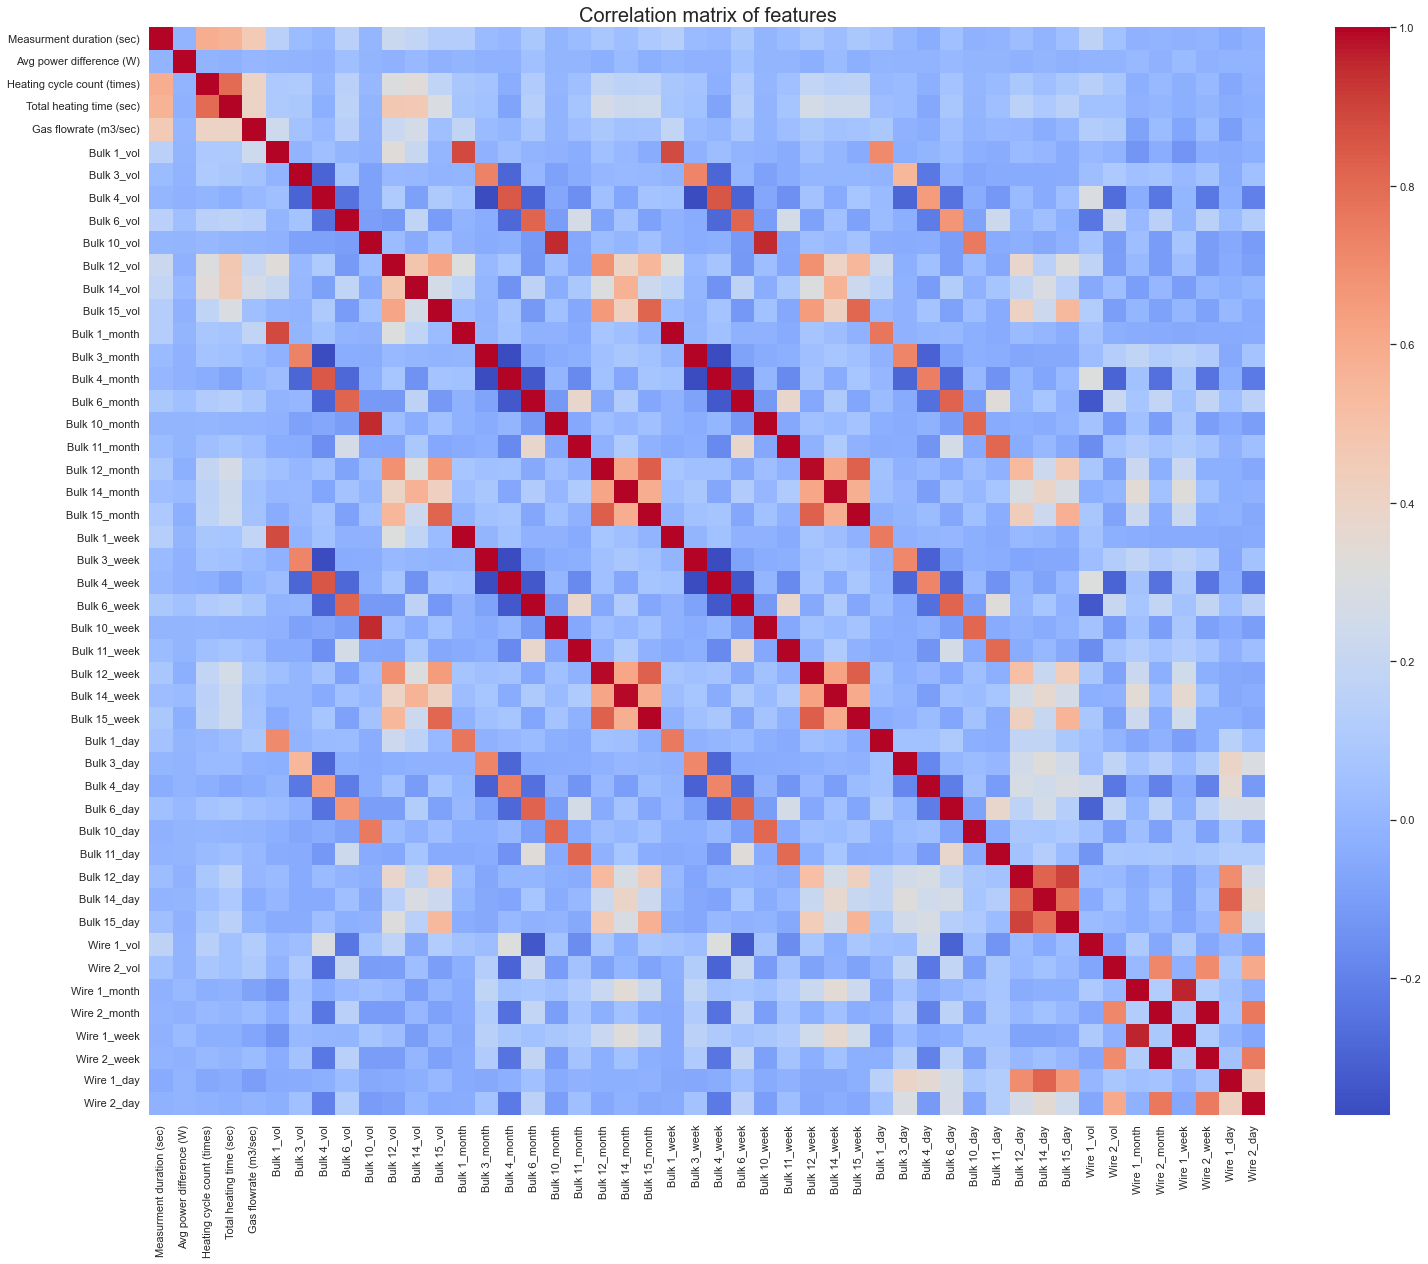

In [74]:
# heatmap of correlation matrix before removing highly correlated features
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(final_df.corr(), cmap='coolwarm', ax=ax)\
   .set_title('Correlation matrix of features', fontsize=20)
plt.show()

Checking for correlation between attributes

In [75]:
# get diagonal and lower triangular pairs of correlation matrix 
def redundant_pairs(data):
    pairs_to_drop = set()
    cols = data.columns
    
    for i in range(0, data.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    return pairs_to_drop

In [76]:
# function for printing top correlated pairs
def top_correlations(data, n=5):
    au_corr = data.corr(method='pearson').abs().unstack()
    labels_to_drop = redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    return au_corr[0:n]

In [77]:
# print out top-5 correlations
print('Top Absolute Correlations')
print(top_correlations(final_df, 25))

Top Absolute Correlations
Bulk 11_month  Bulk 11_week     1.00
Bulk 10_month  Bulk 10_week     1.00
Bulk 1_month   Bulk 1_week      1.00
Bulk 6_month   Bulk 6_week      1.00
Bulk 4_month   Bulk 4_week      1.00
Bulk 3_month   Bulk 3_week      1.00
Wire 2_month   Wire 2_week      1.00
Bulk 15_month  Bulk 15_week     1.00
Bulk 12_month  Bulk 12_week     0.99
Bulk 14_month  Bulk 14_week     0.99
Wire 1_month   Wire 1_week      0.96
Bulk 10_vol    Bulk 10_week     0.95
               Bulk 10_month    0.95
Bulk 12_day    Bulk 15_day      0.90
Bulk 1_vol     Bulk 1_month     0.88
               Bulk 1_week      0.88
Bulk 4_vol     Bulk 4_week      0.85
               Bulk 4_month     0.85
Bulk 12_week   Bulk 15_week     0.83
Bulk 12_month  Bulk 15_month    0.83
               Bulk 15_week     0.82
Bulk 15_month  Bulk 12_week     0.82
Bulk 14_day    Wire 1_day       0.82
Bulk 12_day    Bulk 14_day      0.82
Bulk 6_month   Bulk 6_day       0.82
dtype: float64


Removing highly correlated attributes

In [78]:
# drop highly correlated columns
high_corr = [
    'Bulk 11_week', 
    'Bulk 10_week',
    'Bulk 1_week',
    'Bulk 6_week', 
    'Bulk 4_week', 
    'Bulk 3_week', 
    'Wire 2_week', 
    'Bulk 15_week', 
    'Bulk 12_week',
    'Bulk 14_week',
    'Wire 1_week',
    'Bulk 10_week',
    'Bulk 10_month'  
]

final_df = final_df.drop(columns=high_corr, axis=1)

In [79]:
# print out top-5 correlations
print('Top Absolute Correlations')
print(top_correlations(final_df, 5))

Top Absolute Correlations
Bulk 12_day    Bulk 15_day      0.90
Bulk 1_vol     Bulk 1_month     0.88
Bulk 4_vol     Bulk 4_month     0.85
Bulk 12_month  Bulk 15_month    0.83
Bulk 14_day    Wire 1_day       0.82
dtype: float64


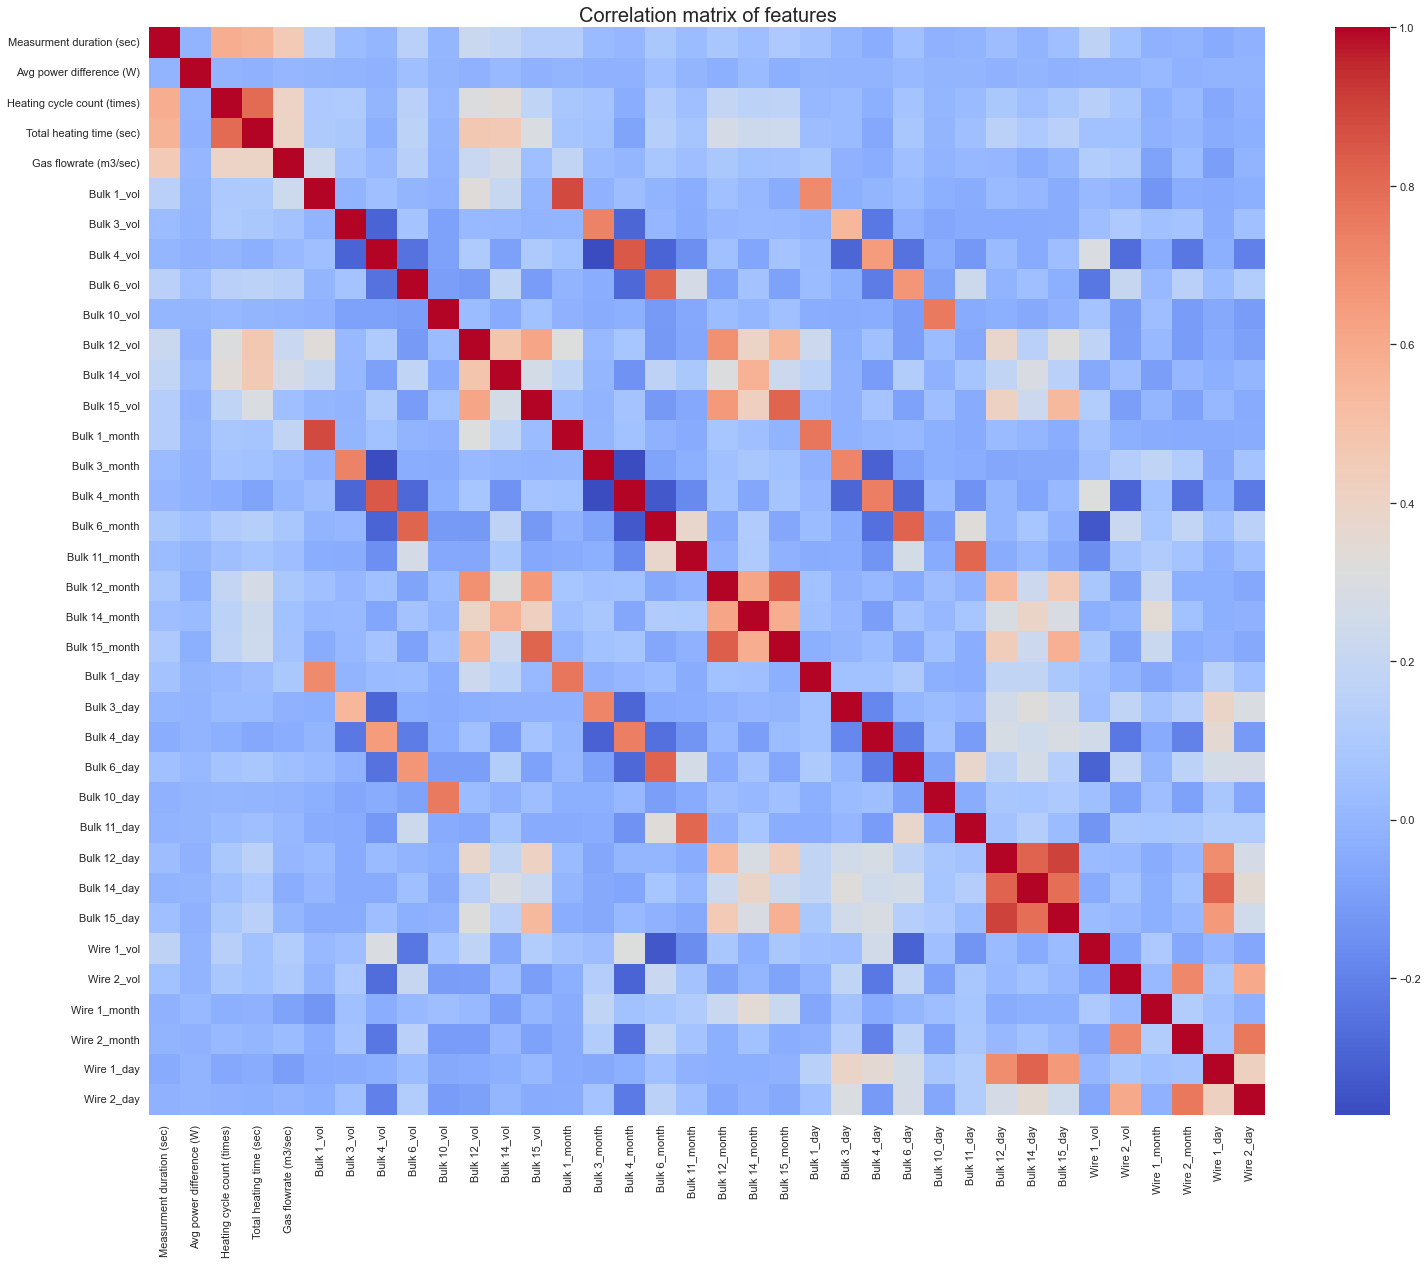

In [80]:
# heatmap of correlation matrix after removing highly correlated features
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(final_df.corr(), cmap='coolwarm', ax=ax)\
   .set_title('Correlation matrix of features', fontsize=20)
plt.show()

In [81]:
# display final dataset with features
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(final_df.head())
    
print('Size of dataset:', final_df.shape)

,Measurment duration (sec),Avg power difference (W),Heating cycle count (times),Total heating time (sec),Gas flowrate (m3/sec),Bulk 1_vol,Bulk 3_vol,Bulk 4_vol,Bulk 6_vol,Bulk 10_vol,Bulk 12_vol,Bulk 14_vol,Bulk 15_vol,Bulk 1_month,Bulk 3_month,Bulk 4_month,Bulk 6_month,Bulk 11_month,Bulk 12_month,Bulk 14_month,Bulk 15_month,Bulk 1_day,Bulk 3_day,Bulk 4_day,Bulk 6_day,Bulk 10_day,Bulk 11_day,Bulk 12_day,Bulk 14_day,Bulk 15_day,Wire 1_vol,Wire 2_vol,Wire 1_month,Wire 2_month,Wire 1_day,Wire 2_day
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,861,0.34,5,1098,29.75,0.0,0.0,43.0,0.0,0.0,206.0,150.0,154.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,60.06,0.00,5.0,0.0,4.0,0.0
2,1305,0.26,4,811,12.56,0.0,0.0,73.0,0.0,0.0,206.0,149.0,154.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,96.05,0.00,5.0,0.0,4.0,0.0
3,1300,0.19,5,655,28.55,0.0,0.0,34.0,0.0,0.0,205.0,152.0,153.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,91.16,0.00,5.0,0.0,4.0,0.0
4,388,0.29,4,741,18.84,0.0,0.0,81.0,0.0,0.0,207.0,153.0,154.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,89.06,0.00,5.0,0.0,4.0,0.0
5,762,0.27,4,869,5.41,0.0,0.0,78.0,0.0,0.0,203.0,151.0,152.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,89.24,9.11,5.0,5.0,4.0,4.0


Size of dataset: (2329, 36)


### ML models

#### Features and target

In [92]:
# create features
X = pd.concat([temp_df.groupby('key')['Temperature']\
    .agg(['first'])\
    .rename(columns={'first': 'Start temperature of steel (C)'})\
    , final_df], axis=1, join='inner')

In [93]:
# create target
y = temp_df.groupby('key')['Temperature']\
    .agg(['last']).loc[X.index]\
    .rename(columns={'last': 'Temperature of steel (C)'})

In [94]:
# reset indeces
X = X.reset_index().drop(['key'], axis=1)    
y = y.reset_index().drop(['key'], axis=1)    

In [95]:
# display target
display(y.head())
print('Number of rows:', len(y)) 

,Temperature of steel (C)
0,1613.0
1,1602.0
2,1599.0
3,1625.0
4,1602.0


Number of rows: 2329


In [96]:
# split train and test data by 75/25 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, shuffle=True
)

#### Transformation pipeline

Building a transformation pipeline

In [97]:
# Fit the models, transform and return prediction
class TypeSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [98]:
# transformer pipline for linear models
transformer_linear = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        
        ('boolean', Pipeline([('selector', TypeSelector('bool')),])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])),  # numericals close
    ])),  # features close
])  # pipeline close

In [99]:
# transformer pipline for non-linear models
transformer_nonlinear = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        
        ('boolean', Pipeline([('selector', TypeSelector('bool')),])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer', SimpleImputer())
            
        ])),  # numericals close
    ])),  # features close
])  # pipeline close

Pipeline for searching optimal parameters via GridSearch

In [100]:
# estimator pipeline
estimators = [
    ('CatBoost Regressor', CatBoostRegressor(
        loss_function='MAE', eval_metric='MAE', random_state=SEED, verbose=0)
    ),
    
    ('Random Forest', RandomForestRegressor(
        criterion='mae', max_depth=10, random_state=SEED)
    ),
    
    ('LGBM Regressor', LGBMRegressor(
        objective='mae', random_state=SEED)
    ),
    
    ('Gradient Boosting', GradientBoostingRegressor(
        criterion='mae', max_depth=10, random_state=SEED)
    ),
    
    ('XGB Regressor', XGBRegressor(
        eval_metric='mae', max_depth=10, random_state=SEED)
    ),
    
    ('Theil-Sen Regression', TheilSenRegressor(
        random_state=SEED)
    ),
    
    ('Lasso Regression', Lasso(
        random_state=SEED)
    ),
    
    ('Support Vector Regression', SVR())
]

In [101]:
# models pipeline
def pipe_builder():
    pipes = {}
    for model in estimators:
        for name in model:
            
            if name in ['Lasso Regression', 'Theil-Sen Regression']:
                pipe = Pipeline(steps=[('data_prep', transformer_linear), model])
                pipe.fit(X_train, y_train)
                pipes[pipe.steps[1][0]] = pipe

            else:
                pipe = Pipeline(steps=[('data_prep', transformer_nonlinear), model])
                pipe.fit(X_train, y_train)
                pipes[pipe.steps[1][0]] = pipe

    return pipes                     

In [102]:
# build pipes
pipes = pipe_builder()

#### Feature importance

Running Feature importance to compare the most important attributes for decision tree models

In [103]:
# function for calculating most important features
def feature_importances(data, models):
    
    tree_based = models
    for name in pipes.keys(): 
        if name in tree_based:
            feat_impt = pipes[name].named_steps[name].feature_importances_
            graph_data = pd.DataFrame()

            graph_data['feature'] = data.columns.values
            graph_data['importance'] = feat_impt
            graph_data_top = graph_data.nlargest(20, 'importance')

            plt.figure(figsize=(12, 10))
            g = sns.barplot(y='feature', x='importance', data=graph_data_top, orient='h')
            g.set_ylabel('Features', fontsize=12)
            g.set_xlabel('Relative Importance')
            g.set_title(name + ' feature importance', fontsize=15)
            g.tick_params(labelsize=12)
            print(' {} '.format(name).center(100, '*'))
            print(graph_data_top['feature'].tolist())
            print('')          

**************************************** CatBoost Regressor ****************************************
['Start temperature of steel (C)', 'Total heating time (sec)', 'Avg power difference (W)', 'Wire 1_vol', 'Measurment duration (sec)', 'Gas flowrate (m3/sec)', 'Bulk 12_vol', 'Bulk 14_vol', 'Bulk 6_month', 'Wire 2_vol', 'Bulk 15_vol', 'Heating cycle count (times)', 'Bulk 1_vol', 'Bulk 4_month', 'Bulk 15_month', 'Bulk 6_day', 'Bulk 6_vol', 'Wire 2_month', 'Bulk 3_vol', 'Bulk 1_month']

****************************************** LGBM Regressor ******************************************
['Total heating time (sec)', 'Measurment duration (sec)', 'Start temperature of steel (C)', 'Avg power difference (W)', 'Gas flowrate (m3/sec)', 'Wire 1_vol', 'Bulk 14_vol', 'Bulk 12_vol', 'Bulk 15_vol', 'Wire 2_vol', 'Bulk 3_vol', 'Bulk 4_vol', 'Heating cycle count (times)', 'Bulk 6_vol', 'Bulk 12_day', 'Wire 1_day', 'Bulk 14_month', 'Wire 2_day', 'Bulk 3_day', 'Bulk 14_day']

******************************

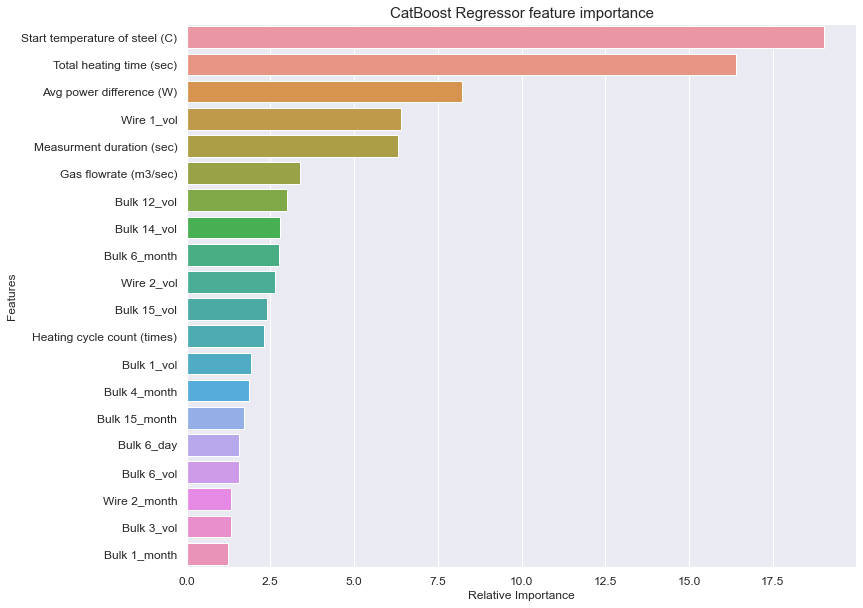

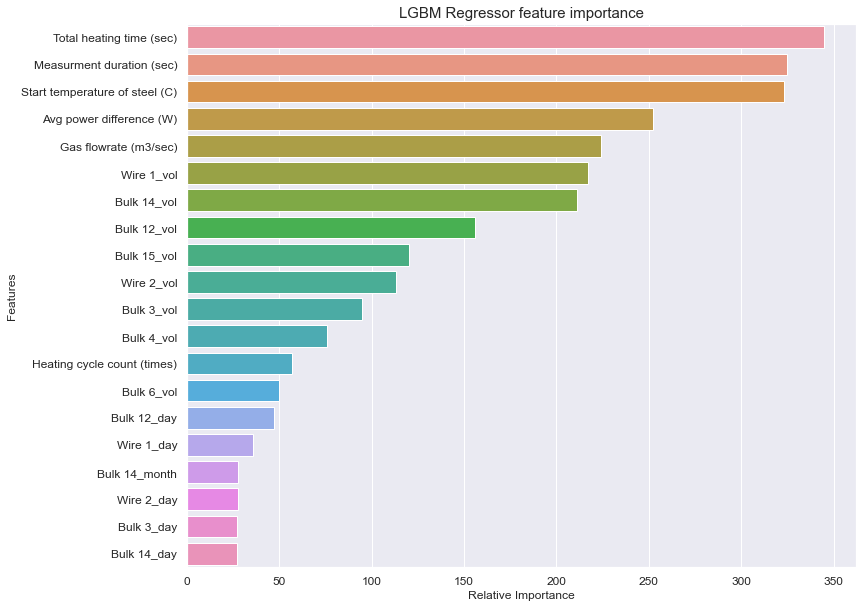

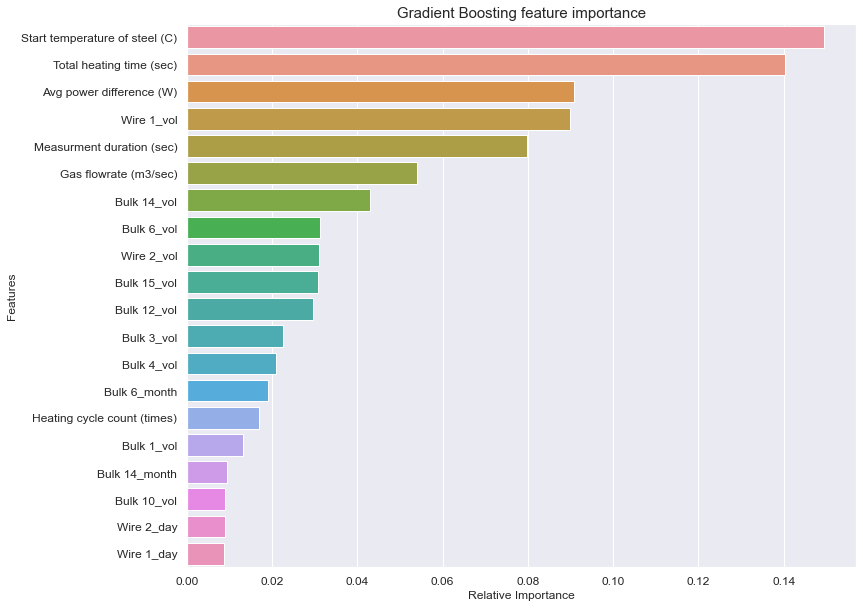

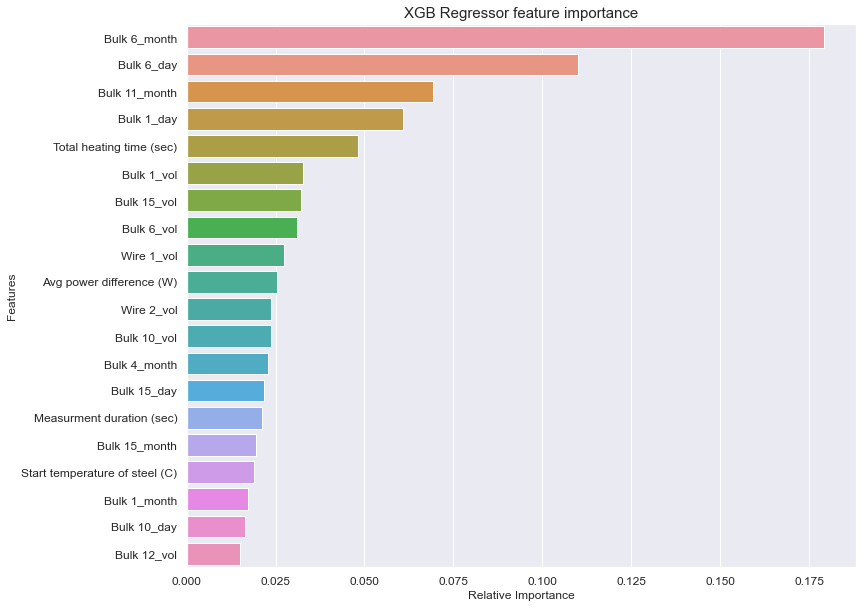

In [114]:
# peint out most important features
tree_based = ['Gradient Boosting', 'CatBoost Regressor', 'XGB Regressor', 'LGBM Regressor']
feature_importances(data=X_train, models=tree_based) 

In [105]:
# most important features
cb_list = ['Start temperature of steel (C)', 'Total heating time (sec)', 'Avg power difference (W)', 
           'Wire 1_vol', 'Measurment duration (sec)', 'Gas flowrate (m3/sec)', 'Bulk 12_vol', 
           'Bulk 14_vol', 'Bulk 6_month', 'Wire 2_vol', 'Bulk 15_vol', 'Heating cycle count (times)', 
           'Bulk 1_vol', 'Bulk 4_month', 'Bulk 15_month', 'Bulk 6_day', 'Bulk 6_vol', 'Wire 2_month', 
           'Bulk 3_vol', 'Bulk 1_month']

rf_list = ['Start temperature of steel (C)', 'Total heating time (sec)', 'Wire 1_vol', 
           'Avg power difference (W)', 'Measurment duration (sec)', 'Gas flowrate (m3/sec)', 
           'Bulk 6_month', 'Wire 2_vol', 'Bulk 14_vol', 'Bulk 6_vol', 'Bulk 12_vol', 'Bulk 15_vol', 
           'Bulk 3_vol', 'Bulk 6_day', 'Heating cycle count (times)', 'Bulk 1_vol', 'Bulk 4_vol', 
           'Bulk 15_month', 'Bulk 3_day', 'Bulk 12_day']

lgb_list = ['Total heating time (sec)', 'Measurment duration (sec)', 'Start temperature of steel (C)', 
            'Avg power difference (W)', 'Gas flowrate (m3/sec)', 'Wire 1_vol', 'Bulk 14_vol', 
            'Bulk 12_vol', 'Bulk 15_vol', 'Wire 2_vol', 'Bulk 3_vol', 'Bulk 4_vol', 
            'Heating cycle count (times)', 'Bulk 6_vol', 'Bulk 12_day', 'Wire 1_day', 'Bulk 14_month', 
            'Wire 2_day', 'Bulk 3_day', 'Bulk 14_day']

xgb_list = ['Bulk 6_month', 'Bulk 6_day', 'Bulk 11_month', 'Bulk 1_day', 'Total heating time (sec)', 
            'Bulk 1_vol', 'Bulk 15_vol', 'Bulk 6_vol', 'Wire 1_vol', 'Avg power difference (W)', 
            'Wire 2_vol', 'Bulk 10_vol', 'Bulk 4_month', 'Bulk 15_day', 'Measurment duration (sec)', 
            'Bulk 15_month', 'Start temperature of steel (C)', 'Bulk 1_month', 'Bulk 10_day', 
            'Bulk 12_vol']                        

In [106]:
# function for finding intersection between two sets
def intersection(lst1, lst2, lst3, list4):
    return list(set(cb_list) & set(lst2) & set(lst3))

In [107]:
# final most important features
intersect = intersection(cb_list, rf_list, lgb_list, xgb_list)
intersect

['Avg power difference (W)',
 'Gas flowrate (m3/sec)',
 'Wire 2_vol',
 'Total heating time (sec)',
 'Bulk 12_vol',
 'Heating cycle count (times)',
 'Start temperature of steel (C)',
 'Bulk 3_vol',
 'Measurment duration (sec)',
 'Bulk 15_vol',
 'Bulk 6_vol',
 'Bulk 14_vol',
 'Wire 1_vol']

Most of the attributes are the same for all models, so the same pre-processed data can be applied to all models

#### Initial model scoring

In [108]:
# initialize metrics and estimator names
_metrics = {'mae': make_scorer(mean_absolute_error)}
estimator_names = [model[0] for model in estimators]

In [109]:
# function for plotting estimator results (boxplots)
def plot_estimators(estimators=estimator_names, n_splits=3, metrics=['mae'], row=2, col=4):
    
    color = [['skyblue', 'olive', 'gold', 'teal'], 
             ['limegreen', 'lightcoral', 'violet', 'khaki']] 

    metrics = {key: _metrics[key] for key in metrics}
    scorers = []
    labels = []
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            labels.append(pipe_name)
            kf = KFold(n_splits)
            model_score = cross_validate(pipe, X_train, y_train, scoring=metrics, cv=kf)
            scorers.append(model_score)
    
    score_lists = {}
    for metric in metrics:
        score_lists[metric] = [score['test_' + metric] for score in scorers]
    
    fig, axs = plt.subplots(row, col, figsize=(18, 5*row))
    fig.suptitle('Mean Absolute Error (MAE)', fontsize=15)
    for idx, (title, _list) in enumerate(score_lists.items()):
        
        if row == 2:

            for idx, column in zip(range(0, col), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[0][column], ax=axs[0, column])
                plot.set(title=estimators[idx])
                                      
            for idx, column in zip(range(col, col*row), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[1][column], ax=axs[1, column])
                plot.set(title=estimators[idx])

        if row == 1:

            for idx, column in zip(range(0, col), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[0][column], ax=axs[column])
                plot.set(title=estimators[idx])                    
    
    plt.show()   

In [110]:
# assign metrics
metrics = {'mae': make_scorer(mean_absolute_error)}     

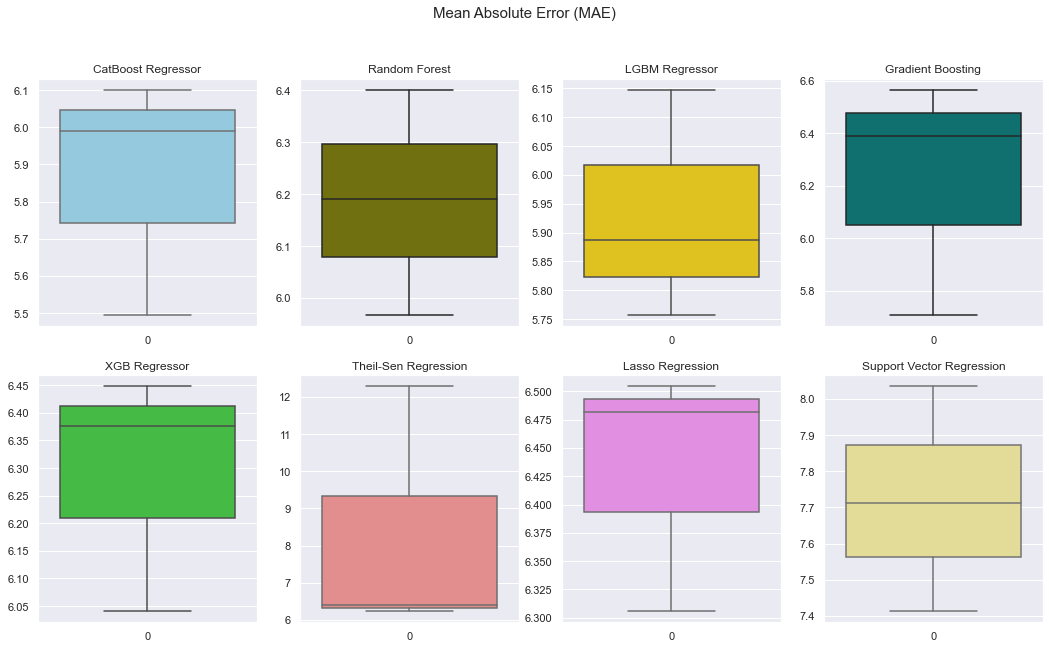

In [111]:
# plot MAE of all models
plot_estimators()    

#### Hyper-parameter tuning

In [112]:
# function for parameter tuning
def tune_param(model, param_grid, data=X_train, target=y_train, cv=3):
    
    param_grid = {model + '__' + key: param_grid[key] for key in param_grid.keys()}

    cv = GridSearchCV(pipes[model], param_grid, cv=cv)
    cv.fit(data, target)

    print('best score: ' + str(cv.best_score_))
    print('best params: ' + str(cv.best_params_))
    results = pd.DataFrame(cv.cv_results_)

##### CatBoost Regressor

In [96]:
# CatBoost Regressor model
pipes['CatBoost Regressor'].named_steps['CatBoost Regressor'].get_params()

{'loss_function': 'MAE', 'eval_metric': 'MAE', 'random_state': 141122}

In [113]:
# find the best combination of parameters 'learning_rate', 'depth', 'bootstrap_type'
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [6, 8, 10],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
}

tune_param('CatBoost Regressor', param_grid)       

best score: -742.914100092119
best params: {'CatBoost Regressor__bootstrap_type': 'Bayesian', 'CatBoost Regressor__depth': 10, 'CatBoost Regressor__learning_rate': 0.01}


##### LGBM Regressor

In [115]:
# LGBM Regressor model
pipes['LGBM Regressor'].named_steps['LGBM Regressor'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'mae',
 'random_state': 141122,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [116]:
# find the best combination of parameters 'boosting_type', 'learning_rate', 'subsample'
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'], 
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

tune_param('LGBM Regressor', param_grid)    

best score: 0.4503565014063822
best params: {'LGBM Regressor__boosting_type': 'gbdt', 'LGBM Regressor__learning_rate': 0.1, 'LGBM Regressor__subsample': 0.6}


In [117]:
# set the best parameters
pipes['LGBM Regressor'].set_params(**{'LGBM Regressor__boosting_type': 'gbdt'})
pipes['LGBM Regressor'].set_params(**{'LGBM Regressor__learning_rate': 0.1})
pipes['LGBM Regressor'].set_params(**{'LGBM Regressor__subsample': 0.6})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer())]))]))])),
                ('LGBM Regressor',
                 LGBMRegressor(objecti

##### XGB Regressor

In [118]:
# XGB Regressor model
pipes['XGB Regressor'].named_steps['XGB Regressor'].get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 141122,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'mae'}

In [119]:
# find the best combination of parameters 'tree_method', 'n_estimators', 'max_depth', 'learning_rate'
param_grid = {
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
}

tune_param('XGB Regressor', param_grid)

best score: 0.48922818138202784
best params: {'XGB Regressor__learning_rate': 0.1, 'XGB Regressor__max_depth': 3, 'XGB Regressor__n_estimators': 200, 'XGB Regressor__tree_method': 'hist'}


In [120]:
# set the best parameters
pipes['XGB Regressor'].set_params(**{'XGB Regressor__tree_method': 'hist'})
pipes['XGB Regressor'].set_params(**{'XGB Regressor__n_estimators': 200})
pipes['XGB Regressor'].set_params(**{'XGB Regressor__max_depth': 3})
pipes['XGB Regressor'].set_params(**{'XGB Regressor__learning_rate': 0.1})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer())]))]))])),
                ('XGB Regressor',
                 XGBRegressor(base_scor

##### Gradient Boosting

In [121]:
# Random Forest model
pipes['Gradient Boosting'].named_steps['Gradient Boosting'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'mae',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 141122,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [122]:
# find the best combination of parameters 'max_depth', 'n_estimators', 'learning_rate'
param_grid = {
    'max_depth': [10, 20, 30, 50],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1]
}

tune_param('Gradient Boosting', param_grid)

best score: 0.40828628787429744
best params: {'Gradient Boosting__learning_rate': 0.1, 'Gradient Boosting__max_depth': 10, 'Gradient Boosting__n_estimators': 200}


In [123]:
# set the best parameters
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__max_depth': 10})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__n_estimators': 200})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__learning_rate': 0.1})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer())]))]))])),
                ('Gradient Boosting',
                 GradientBoostingRe

#### Post-tuning scores

Printing top-4 models with optimized hyperparameters

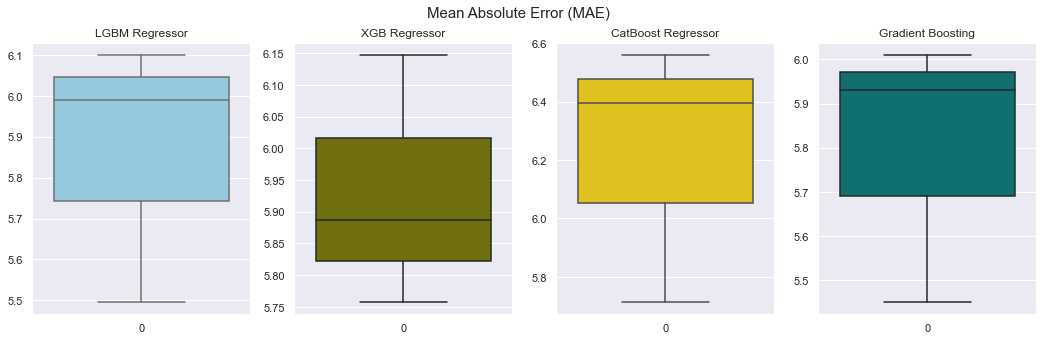

In [124]:
# plot MAE of tuned models
plot_estimators(['LGBM Regressor', 'XGB Regressor', 'CatBoost Regressor', 'Gradient Boosting'], row=1)

#### Final checking

Model validation after parameter optimization

##### CatBoost Regressor

In [131]:
# MAE on training data
cb = pipes['CatBoost Regressor'].named_steps['CatBoost Regressor']
cv_cb = KFold(n_splits=7)
n_scores_cb = cross_val_score(cb, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv_cb)
print('MAE (CatBoost Regressor): %.3f' % abs(max(n_scores_cb)))

MAE (CatBoost Regressor): 5.091


In [133]:
# MAE on testing data
pred_cb = cb.predict(X_test)
score_cb = mean_absolute_error(y_test, pred_cb)
print('MAE (test):', round(score_cb, 3))

MAE (test): 5.808


##### LGBM Regressor

In [127]:
# MAE on training data
lgb = pipes['LGBM Regressor'].named_steps['LGBM Regressor']
cv_lgb = KFold(n_splits=7)
n_scores_lgb = cross_val_score(lgb, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv_lgb)
print('MAE (LGBM Regressor): %.3f' % abs(max(n_scores_lgb)))

MAE (LGBM Regressor): 5.202


In [134]:
# MAE on testing data
pred_lgb = lgb.predict(X_test)
score_lgb = mean_absolute_error(y_test, pred_lgb)
print('MAE (test):', round(score_lgb, 3))

MAE (test): 5.826


##### XGB Regressor

In [128]:
# MAE on training data
xgb = pipes['XGB Regressor'].named_steps['XGB Regressor']
cv_xgb = KFold(n_splits=7)
n_scores_xgb = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv_xgb)
print('MAE (XGB Regressor): %.3f' % abs(max(n_scores_xgb)))

MAE (XGB Regressor): 5.213


In [135]:
# MAE on testing data
pred_xgb = xgb.predict(X_test)
score_xgb = mean_absolute_error(y_test, pred_xgb)
print('MAE (test):', round(score_xgb, 3))

MAE (test): 6.253


##### Gradient Boosting

In [129]:
# MAE on training data
gb = pipes['Gradient Boosting'].named_steps['Gradient Boosting']
cv_gb = KFold(n_splits=7)
n_scores_gb = cross_val_score(gb, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv_gb)
print('MAE (Gradient Boosting): %.3f' % abs(max(n_scores_gb)))

MAE (Gradient Boosting): 5.494


In [136]:
# MAE on testing data
pred_gb = gb.predict(X_test)
score_gb = mean_absolute_error(y_test, pred_gb)
print('MAE (test):', round(score_gb, 3))

MAE (test): 6.129


In [158]:
# # function for calculating MAE
# def print_predictions(target, predictions):
#     print('mae: '+ str(mean_absolute_error(target, predictions)))

In [159]:
# # print out MAE for each model
# for name in pipes.keys():
#     print(name)
#     predictions = pipes[name].predict(X_test)
#     print_predictions(y_test, predictions)
#     print()

Checking the model for adequacy

In [137]:
# Dummy Regressor model
dr = DummyRegressor(strategy='mean')

# fit the model for the 1st target
dr.fit(X_train, y_train)

# make predictions on testing data
pred_dummy = dr.predict(X_test)
dummy_score = mean_absolute_error(pred_dummy, y_test)
print('MAE (dummy regressor):', round(dummy_score, 3))

MAE (dummy regressor): 8.214


Finding the combo with the best metric on test data

In [138]:
# list of final estimators
final_estimators = ['LGBM Regressor', 'XGB Regressor', 'CatBoost Regressor', 'Gradient Boosting']

In [141]:
# function for getting final score from differen combos
def final_combo(X_train, y_train, X_test, y_test):    
    
    combos = []
    for L in range(1, len(final_estimators) + 1):
        for subset in combinations(final_estimators, L):
            combos.append(list(subset))

    combo_names = []
    mae = []

    for combo in combos:
        estimators = [(name, clone(pipes[name].named_steps[name])) for name in combo] 
        vote = Pipeline(
            steps=[
                ('data_prep', transformer_nonlinear), 
                ('voter', VotingRegressor(estimators))
            ]
        )
        
        vote.fit(X_train, y_train)
        predictions = vote.predict(X_test)

        mae.append(mean_absolute_error(y_test, predictions))
        combo_names.append(str(list(combo)))
        
    score = pd.DataFrame()
    score['combo'] = combo_names
    score['mae'] = mae

    return score

In [144]:
# scores of combos
combo_df = final_combo(X_train, y_train, X_test, y_test)

In [146]:
# show top-10 models and their MAE scores
display(combo_df.head(10).sort_values(by='mae', ascending=True).reset_index(drop=True))

,combo,mae
0,"['LGBM Regressor', 'XGB Regressor']",5.74
1,"['XGB Regressor', 'CatBoost Regressor']",5.75
2,"['LGBM Regressor', 'CatBoost Regressor']",5.75
3,['CatBoost Regressor'],5.81
4,['LGBM Regressor'],5.83
5,"['CatBoost Regressor', 'Gradient Boosting']",5.84
6,"['LGBM Regressor', 'Gradient Boosting']",5.85
7,"['XGB Regressor', 'Gradient Boosting']",5.87
8,['XGB Regressor'],5.87
9,['Gradient Boosting'],6.13


## Step 4. Compilation of a report

#### 1. Final review of the work plan

In accordance with the work plan, all key aims are completed, namely:
- Calculation of technological process parameters
- Statistical analysis and data preprocessing
- Building machine learning models
- Model optimization for solving the regression problem

#### 2. Difficulties during project implementation

The volume and loading time of bulk materials added during the melting process varies greatly from trial to trial. After visualization, it turns out that most of the materials are not used during steel processing (less than 100 times), which means that they can be removed. Similarly, wire materials Wire 1 and Wire 2 are only used on average 250 and 150 times, respectively. Due to the fact that there are NaN in the temperature readings, trials in which less than 2 readings are excluded from further analysis.

#### 3. Key steps for meeting aims defined

At the initial stage of the project, an exploratory data analysis is carried out. Data distributions for temperature, inert gas flowrate and electrode characteristics are normal. Most of the data lies in the interquartile range, so additional preprocessing to eliminate outliers is not required.

Accordance the technical requirements, the process parameters calculated from the available data are added: the time between the first and last temperature measurement, the total time of heating by the electrodes, the number of starts of heating by the electrodes and the average ratio of active and reactive power. After adding these attributes, the statistical parameters for verification (min, max, avg, median) are calculated, which do not reveal errors in the calculations or incorrect data received from the process equipment. Additionally, data on the month, week and day of the test is extracted. After the removal of strongly correlated attributes, their total number is 37, while the correlation coefficient does not exceed 0.9.

Based on Feature importance, the most significant input parameters are visualized for temperature prediction. Top-13 parameters for boosted models are eventually identified:
- Start temperature of steel
- Avg power difference
- Gas flowrate
- Total heating time
- Heating cycle count
- Measurment duration
- Wire 1_vol
- Wire 2_vol
- Bulk 3_vol
- Bulk 6_vol
- Bulk 12_vol
- Bulk 14_vol
- Bulk 15_vol

To predict the final temperature, both linear models (TheilSen, Lasso, SVM) and non-linear models (RandomForest, GradientBoosting, XGBoost, LightGBM, CatBoost) are chosen. After building a Pipeline and performing a Grid Search on the main hyper-parameters, the best MAE metrics are achieved by boosting algorithms: GradientBoosting, XGBoost, LightGBM, CatBoost. Feature Importance technique is additionally applied to determine the attributes that most affect the quality of the machine learning model, which demonstrates that most of the attributes should be used in each of their models. Therefore, there is no need to apply a different set of attributes to different models.

#### 4. Final ML model and its metrics

The best metric on cross-validation MAE=5.09 for the CatBoost Regressor model.

The optimal hyper-parameters for this model are:
- loss_function: MAE
- eval_metric: MAE
- bootstrap_type: Bayesian
- depth: 10
- learning_rate: 0.01

The model is also checked for adequacy using the DummyRegressor. In the final part of the study, the trained models are tested with test data, which also shows a low error with MAE metric in the region of 5.7..5.8. As a result, the quality of the models corresponds to the target stated in the technical requirements.